In [1]:
import os, sys

In [2]:
import demes, demesdraw, sparse
import matplotlib.pyplot as plt
import numpy as np

from momi3.Params import Params
from momi3.MOMI import Momi

# Load

<AxesSubplot:ylabel='time ago (generations)'>

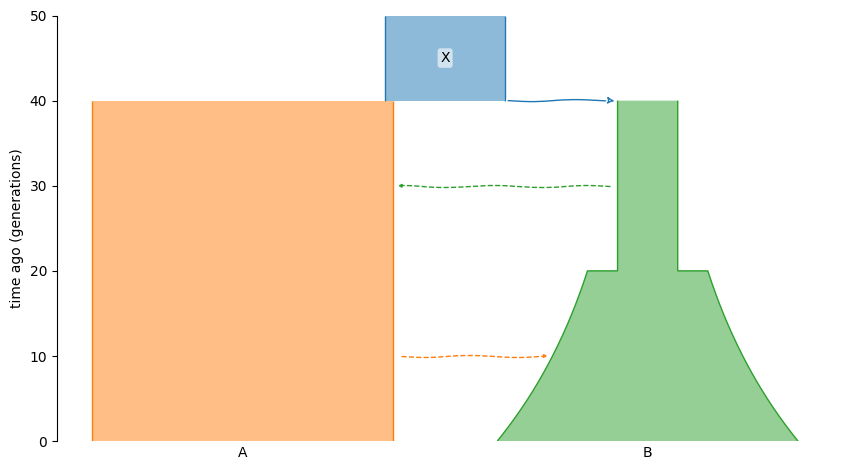

In [3]:
# Load demes graph
demo = demes.load(f"TwoDemes/TwoDemes.yml")
demesdraw.tubes(demo)

In [4]:
sampled_demes = ["A", "B"]
sample_sizes = [10, 16]

In [5]:
# Construct momi
momi = Momi(demo, sampled_demes=sampled_demes, sample_sizes=sample_sizes, jitted=True)

In [6]:
sfs_spec_momi = momi.sfs_spectrum()

In [7]:
sfs_spec_momi /= sfs_spec_momi.sum()

In [8]:
jsfs = sparse.load_npz("TwoDemes/TwoDemes.npz")

/tmp/ipykernel_878024/2959819326.py:2: RuntimeWarning: divide by zero encountered in log
  ax1.imshow(np.log(sfs_spec_momi))
/tmp/ipykernel_878024/2959819326.py:3: RuntimeWarning: divide by zero encountered in log
  ax2.imshow(np.log(jsfs.todense()))


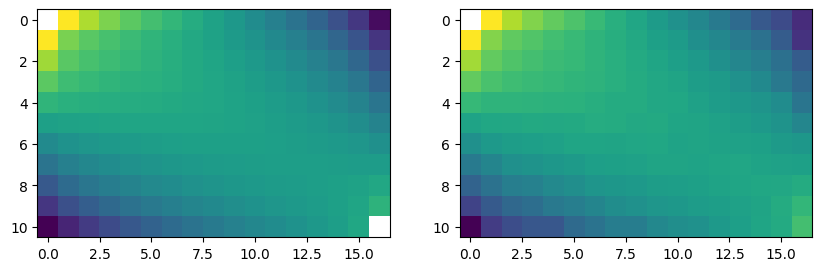

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.imshow(np.log(sfs_spec_momi))
ax2.imshow(np.log(jsfs.todense()))

In [10]:
params = Params(momi)

In [11]:
# Set the parameters you want to infer
params.set_train("eta_3", True)
params.set_train("eta_1", True)
params.set_train("pi_0", True)
params.set_train("tau_4", True)

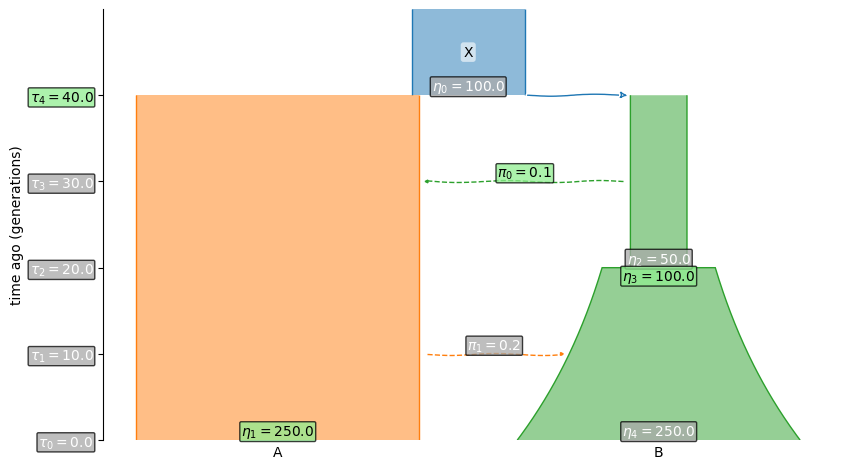

In [12]:
params.tubes(show_letters=True)

## profile likelihood example

In [13]:
# Normal
from scipy import stats, optimize
import numpy as np
import jax.numpy as jnp
import jax

In [14]:
def gen_sym_cov_matrix(p, corr):
    Sigma = np.ones((p, p)) * corr
    Sigma += np.diag(p * [1 - corr])
    return Sigma

In [15]:
def model(b, X):
    return X @ b

In [16]:
n = 100
p = 10
corr = 0.8

b = np.random.randn(p)

np.random.seed(108)

X = stats.multivariate_normal(mean=p * [0], cov=gen_sym_cov_matrix(p, corr)).rvs(n)
eps = stats.norm(0, np.sqrt(p)*0.4).rvs(n)
y = model(b, X) + eps

In [17]:
@jax.jit
def loglik(b, X, y):
    yhat = model(b, X)
    return jnp.sum(jnp.power(y - yhat, 2))

jvag = jax.value_and_grad(loglik)

def f(b, X, y, out=None):
    v, g = jvag(b, X, y)
    if out is None:
        pass
    else:
        g = g.at[out].set(0.)
    return v, g

fun = lambda b: f(b, X, y, out=0)

In [18]:
def get_mle(b, out_index=None, out_val=None):
    b = b.copy()
    b1 = out_index is None
    b2 = out_val is None
    
    if b1 and b2:
        # General MLE
        fun = lambda b: f(b, X, y)
    elif not b1 and not b2:
        b[out_index] = out_val
        fun = lambda b: f(b, X, y, out=out_index)
    else:
        raise ValueError("Wrong Config")
        
    opt_res = optimize.minimize(fun, jac=True, x0=b, method='SLSQP')    
    return opt_res

In [19]:
mle_res = get_mle(b)

mle_loglik = -mle_res.fun
b_hat = mle_res.x

b_hat0 = b_hat[0]

In [20]:
H = jax.hessian(loglik)(b_hat, X, y)
std_error = np.sqrt(np.diag(np.linalg.pinv(H)))
std0 = std_error[0]
rv = stats.norm(loc=b_hat0, scale=std0)

In [21]:
xlim = [b_hat0 - 3*std0, b_hat0 + 3*std0]
b_0s = np.linspace(xlim[0], xlim[1], 50)

logliks = np.array([-get_mle(b, 0, b_0).fun for b_0 in b_0s])

In [22]:
myhline = mle_loglik - 2

In [23]:
sorted_ind = np.argsort(np.abs(logliks - myhline))
v1 = sorted_ind[0]
for i, val in enumerate(sorted_ind[1:]):
    if abs(v1 - val) == (i + 1):
        pass
    else:
        v2 = val
        break

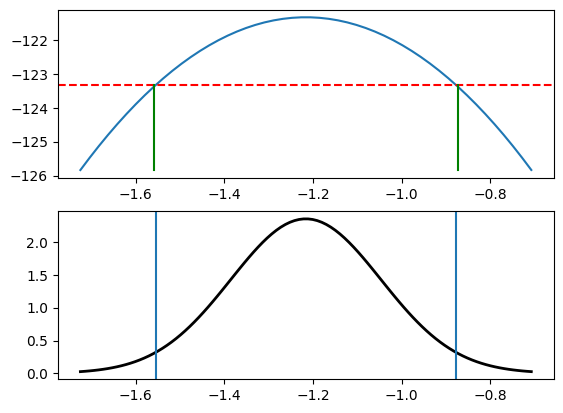

In [24]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(b_0s, logliks)
axs[0].axhline(myhline, color='red', linestyle='dashed')
axs[0].plot([b_0s[v1], b_0s[v1]], [myhline, min(logliks)], color = 'green')
axs[0].plot([b_0s[v2], b_0s[v2]], [myhline, min(logliks)], color = 'green')

x = np.linspace(xlim[0], xlim[1], 100)
axs[1].plot(x, rv.pdf(x), 'k-', lw=2)
axs[1].axvline(b_hat0 - 2*std0)
axs[1].axvline(b_hat0 + 2*std0)

### Write a function to get the MLE given a fixed value of "pi_1"

In [25]:
import scipy
def MLE_given_pi_1(val_pi_1):
    params.set('pi_1', val_pi_1)
    
    theta_train_0 = np.array(params._theta_train)
    train_keys = params._train_keys
    
    
    # We'd like to minimize -\ell(theta_train; data, theta_nuisance)
    def fun(theta_train, train_keys=train_keys):
        theta_train_dict = {}
        for key, val in zip(train_keys, theta_train):
            theta_train_dict[key] = float(val)
        val, grad = momi.negative_loglik_with_gradient(
            params, jsfs, theta_train_dict, return_array=True
        )
        return val, grad

    # Optimizer spesifications:
    method = "trust-constr"
    optimizer_options = dict(initial_tr_radius=0.01)

    # momi model constraints:

    LinearConstraints = params._linear_constraints_for_scipy()

    # Running the scipy optimizer
    res = scipy.optimize.minimize(
        fun=fun,
        x0=theta_train_0,
        jac=True,
        constraints=LinearConstraints,
        method=method,
        options=optimizer_options,
    )
    
    return res

In [26]:
x = MLE_given_pi_1(0.1).x

/home/enes/enesenv/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [27]:
momi.loglik_with_gradient(params, jsfs)[0]

Array(-906679.06, dtype=float32)

In [28]:
momi.loglik_with_gradient(params, jsfs, dict(zip(params._train_keys, x)))[0]

Array(-905532.5, dtype=float32)